In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coding Dojo/Project/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# **Data Cleaning**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
# Set Item_Identifier as the index
df = df.set_index('Item_Identifier')

In [ ]:
# Item_Weight and Outlet_Size are both missing data
# The data for both Item_weight and Outlet_Size can be dropped.
df.drop(columns = 'Item_Weight', inplace = True)
df.drop(columns = 'Outlet_Size', inplace = True)

In [ ]:
# Check for any duplicate rows
df.duplicated().any()

False

In [ ]:
# Check for spelling errors or inconsistencies
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
# There are inconsistencies with the spelling of low fat and regular so fix that
df.loc[df['Item_Fat_Content'] == 'LF', 'Item_Fat_Content'] = 'Low Fat'
df.loc[df['Item_Fat_Content'] == 'reg', 'Item_Fat_Content'] = 'Regular'
df.loc[df['Item_Fat_Content'] == 'low fat', 'Item_Fat_Content'] = 'Low Fat'
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# Check for inconsistencies with the spelling of item types
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [ ]:
# Check for inconsistencies with outlet location type
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
# Check for inconsistencies with outlet type
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
# Check for any more missing data
df.isnull().sum()

Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
df.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,
FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.1380
DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Tier 3,Supermarket Type2,443.4228
FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Tier 1,Supermarket Type1,2097.2700
FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Tier 3,Grocery Store,732.3800
NCD19,Low Fat,0.000000,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1,994.7052


# **Graph #1**

In [ ]:
# Filters
low_fat = df['Item_Fat_Content'] == 'Low Fat'
regular = df['Item_Fat_Content'] == 'Regular'

# Dataframes of the filters
df_lf_sales = df[low_fat]
df_reg_sales = df[regular]

# Change column name
df_lf_sales = df_lf_sales.rename(columns = {'Item_Outlet_Sales' : 'Low Fat Sales'})
df_reg_sales = df_reg_sales.rename(columns = {'Item_Outlet_Sales' : 'Regular Sales'})

# Sum of sales of low fat and regular for each item type
lf_sales_gb = df_lf_sales.groupby(['Item_Type'])[['Low Fat Sales']].sum()
reg_sales_gb = df_reg_sales.groupby(['Item_Type'])[['Regular Sales']].sum()

In [ ]:
# Concatenate new dataframe
item_type_sales = pd.concat([lf_sales_gb, reg_sales_gb], axis = 1)
item_type_sales.index.name = 'Item_Type'
item_type_sales.drop(index = ['Hard Drinks', 'Health and Hygiene', 'Household', 'Others'], inplace = True)
total_sales = item_type_sales['Low Fat Sales'] + item_type_sales['Regular Sales']
item_type_sales['Total Sales'] = total_sales
item_type_sales = item_type_sales.sort_values('Total Sales')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

item_type_sales

,Low Fat Sales,Regular Sales,Total Sales
Item_Type,,,
Seafood,70588.12,78280.10,148868.22
Breakfast,99441.89,132857.06,232298.95
Starchy Foods,209790.92,141610.33,351401.25
Breads,305680.76,247556.42,553237.19
Soft Drinks,761259.07,131638.65,892897.72
Meat,346054.88,571510.74,917565.61
Baking Goods,580523.67,685001.67,1265525.34
Canned,753171.60,690979.89,1444151.49
Dairy,896682.79,625911.26,1522594.05


''

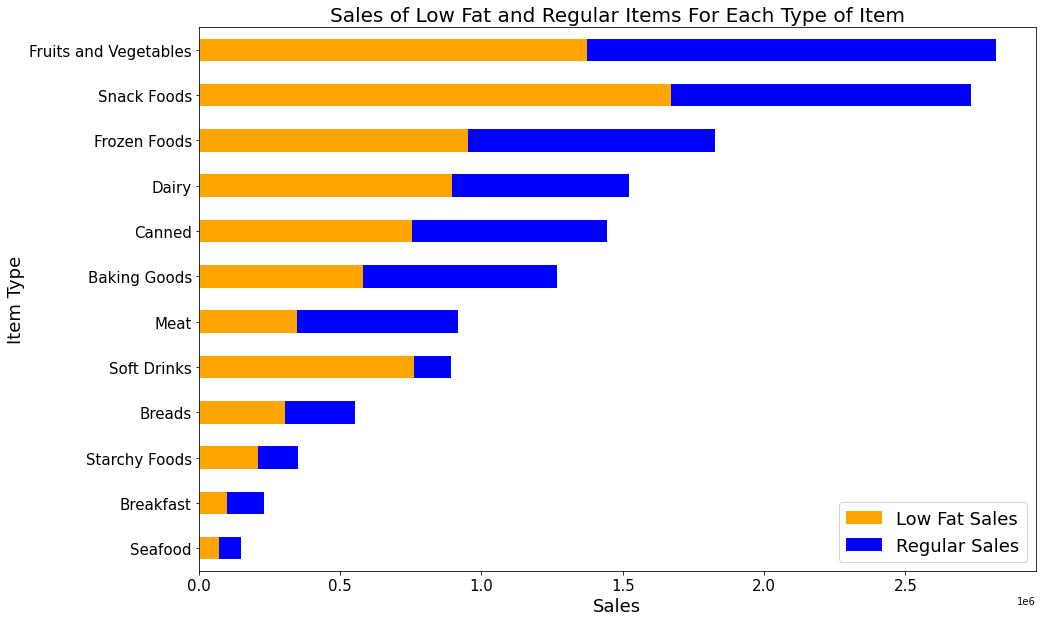

In [ ]:
# Create a stacked bar chart of sales of low fat and regular items for each item type
item_type_sales.plot(y = ['Low Fat Sales', 'Regular Sales'], kind = 'barh', stacked = True, figsize = (15,10), color = ['orange', 'blue'])

plt.xlabel('Sales', fontsize = 18)
plt.xticks(fontsize = 15)
plt.ylabel('Item Type', fontsize = 18)
plt.yticks(fontsize = 15)
plt.title('Sales of Low Fat and Regular Items For Each Type of Item', fontsize = 20)
plt.legend(loc = 4, fontsize = 18)
;

# **Graph #2**

In [ ]:
# Item sales from each store
outlet_sales_gb = df.groupby(['Outlet_Type', 'Outlet_Identifier'])[['Item_Outlet_Sales']].sum()
outlet_sales = pd.concat([outlet_sales_gb], axis = 1)
outlet_sales

Item_Outlet_Sales
Outlet_Type       Outlet_Identifier                   
Grocery Store     OUT010                     188340.17
                  OUT019                     179694.09
Supermarket Type1 OUT013                    2142663.58
                  OUT017                    2167465.29
                  OUT035                    2268122.94
                  OUT045                    2036725.48
                  OUT046                    2118395.17
                  OUT049                    2183969.81
Supermarket Type2 OUT018                    1851822.83
Supermarket Type3 OUT027                    3453926.05

''

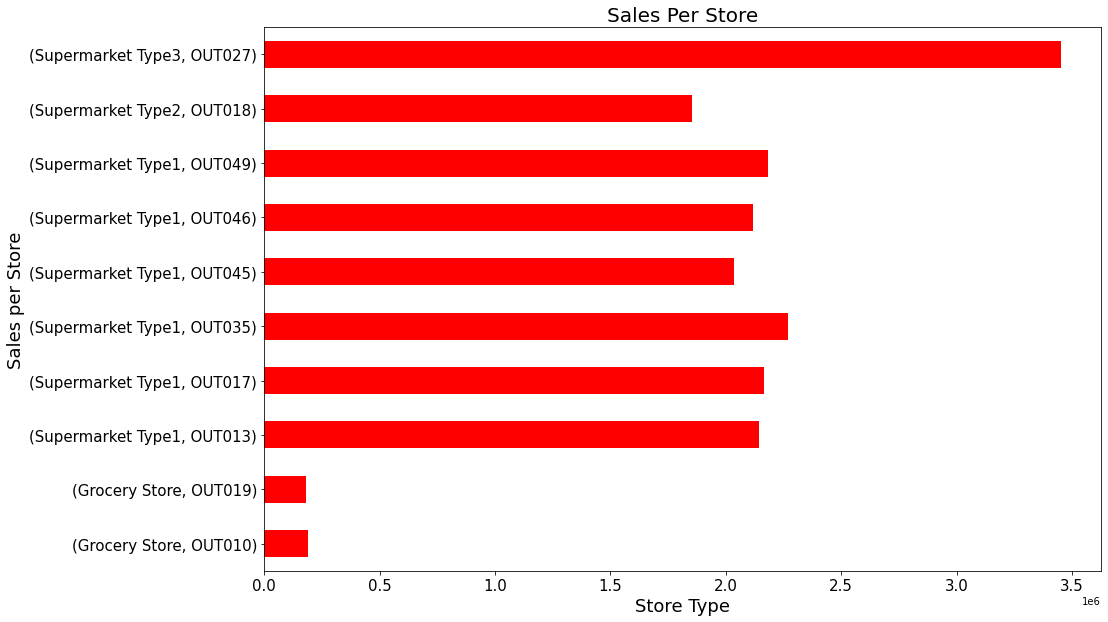

In [ ]:
# Create a bar chart of sales per store
outlet_sales.plot(kind = 'barh', figsize = (15,10), color = 'red', legend = None)

plt.xlabel('Store Type', fontsize = 18)
plt.xticks(fontsize = 15, rotation = 0)
plt.ylabel('Sales per Store', fontsize = 18)
plt.yticks(fontsize = 15)
plt.title('Sales Per Store', fontsize = 20)
;

# **Histogram**

''

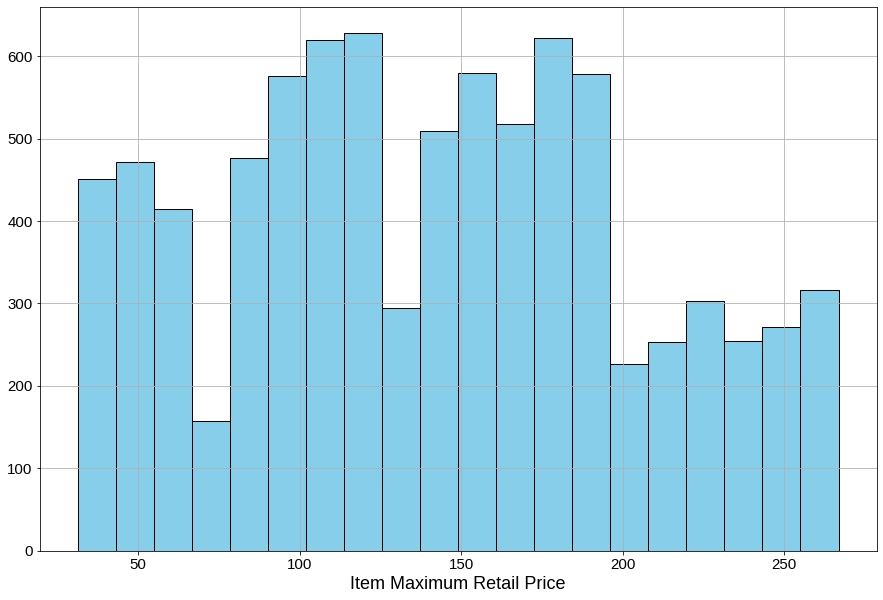

In [ ]:
# Histogram of item mrp
df['Item_MRP'].hist(bins = 20, color = 'skyblue', edgecolor = 'black', figsize = (15,10))
plt.style.use('seaborn')

plt.xlabel('Item Maximum Retail Price', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
;

''

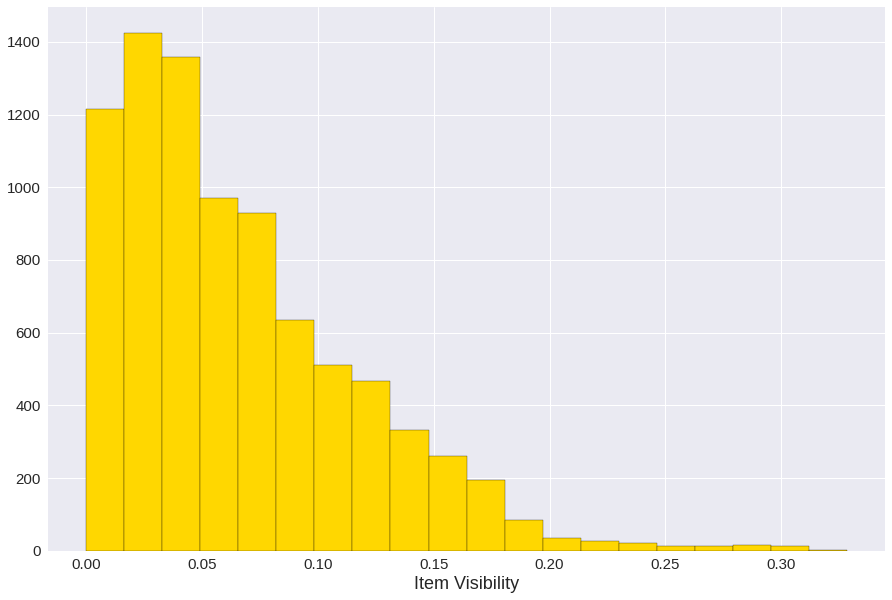

In [ ]:
# Histogram of item visibility
df['Item_Visibility'].hist(bins = 20, color = 'gold', edgecolor = 'black', figsize = (15,10),)
#plt.style.use('seaborn')

plt.xlabel('Item Visibility', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
;

# **Boxplot**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


''

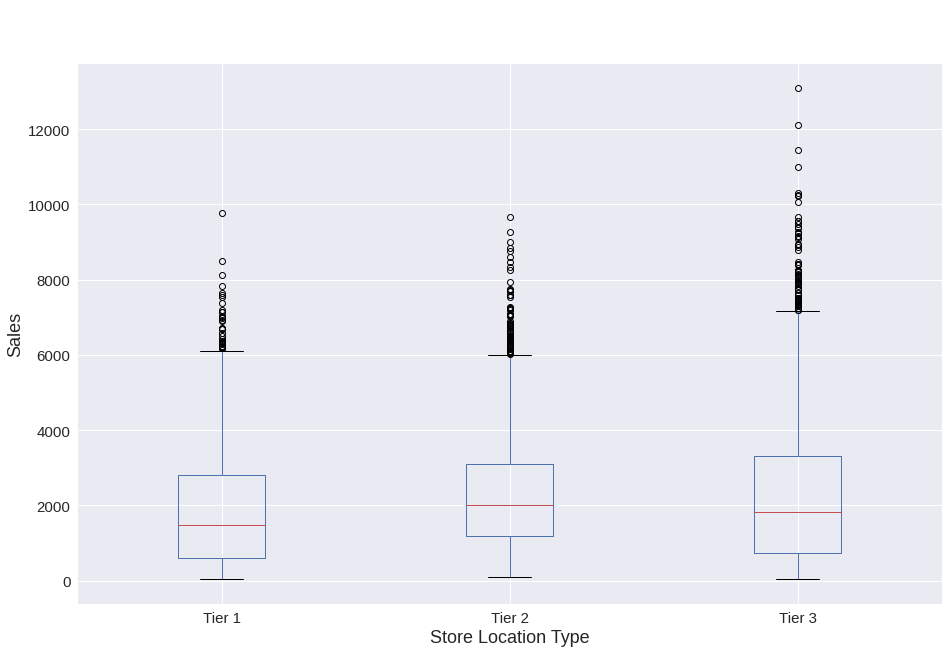

In [ ]:
# Boxplot of sales by outlet location type
df.boxplot(column = 'Item_Outlet_Sales', by = 'Outlet_Location_Type', figsize = (15,10))

plt.title(' ')
plt.suptitle(' ')
plt.xlabel('Store Location Type', fontsize = 18)
plt.xticks(fontsize = 15)
plt.ylabel('Sales', fontsize = 18)
plt.yticks(fontsize = 15)
;

# **Prediction Models**

In [ ]:
# Map the replacement dictionary
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].map({1985: 0, 1987: 1, 1997: 2, 1998: 3, 1999: 4, 2002: 5, 2004: 6, 2007: 7, 2009: 8})

In [ ]:
df.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,
FDA15,Low Fat,0.02,Dairy,249.81,OUT049,4,Tier 1,Supermarket Type1,3735.14
DRC01,Regular,0.02,Soft Drinks,48.27,OUT018,8,Tier 3,Supermarket Type2,443.42
FDN15,Low Fat,0.02,Meat,141.62,OUT049,4,Tier 1,Supermarket Type1,2097.27
FDX07,Regular,0.00,Fruits and Vegetables,182.09,OUT010,3,Tier 3,Grocery Store,732.38
NCD19,Low Fat,0.00,Household,53.86,OUT013,1,Tier 3,Supermarket Type1,994.71


In [ ]:
# One-hot encode nominal categorical variables
ohe = pd.get_dummies(df, columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type'], drop_first = True)

In [ ]:
ohe.head()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
Item_Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FDA15,0.02,249.81,4,3735.14,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
DRC01,0.02,48.27,8,443.42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
FDN15,0.02,141.62,4,2097.27,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
FDX07,0.00,182.09,3,732.38,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
NCD19,0.00,53.86,1,994.71,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
# Arrange data into features matrix and target vector
X = ohe[['Item_Visibility',
        'Item_MRP',
        'Outlet_Establishment_Year',
        'Item_Fat_Content_Regular',
        'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
        'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
        'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']]
y = ohe['Item_Outlet_Sales']

# **KNN without train-test-split**

In [ ]:
# Standardize data, fit on x, and transform x
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X);

In [ ]:
# KNN regressor
knn = KNeighborsRegressor(n_neighbors = 2)
knn.fit(X_scaled, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [ ]:
# KNN r^2 score
knn.score(X_scaled, y)

0.7922014182508275

# **Linear Regression without train-test-split**

In [ ]:
# Linear Regression
reg = LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Linear regression r^2 score
reg.score(X, y)

0.56376350454416

# **KNN with train-test-split**

In [ ]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3 , random_state=22)

In [ ]:
# Standardize data
scaler = StandardScaler()
# Fit on x
scaler.fit(X_train)
# Transform x_train and x_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# KNN regressor with train-test-split
knn_tts = KNeighborsRegressor(n_neighbors=9)
knn_tts.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [ ]:
# KNN training r^2 score
knn_tts.score(X_train, y_train)

0.6086915993960061

In [ ]:
# KNN testing r^2 score
knn_tts.score(X_test, y_test)

0.4657519495032474

# **Linear Regression with train-test-split**

In [ ]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=22)

In [ ]:
# Linear regression with train-test-split
reg_tts = LinearRegression()
reg_tts.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Linear regression training r^2 score
reg_tts.score(X_train, y_train)

0.5689146079638765

In [ ]:
# Linear regression testing r^2 score
reg_tts.score(X_test, y_test)

0.5497249251596898

# **Bagged Trees**

In [ ]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=22)

In [ ]:
# Bagged trees regressor
bt = BaggingRegressor(n_estimators=103, random_state=22)
bt.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=103,
                 n_jobs=None, oob_score=False, random_state=22, verbose=0,
                 warm_start=False)

In [ ]:
# Bagged trees regressor training r^2 score
bt.score(X_train, y_train)

0.9382226382055393

In [ ]:
# Bagged trees regressor testing r^2 score
bt.score(X_test, y_test)

0.5353826781090645

# **Random Forest**

In [ ]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=22)

In [ ]:
# Random forest regressor
rf = RandomForestRegressor(n_estimators=115, random_state=22)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=115, n_jobs=None, oob_score=False,
                      random_state=22, verbose=0, warm_start=False)

In [ ]:
# Random forest regressor training r^2 score
rf.score(X_train, y_train)

0.9389963762954674

In [ ]:
# Random forest regressor testing r^2 score
rf.score(X_test, y_test)

0.5344790169437481